# Домашнее задание №1

- Студент: Алексей Ярошенко
- Группа: MADE-DS-32
- Email: aleksey.yaroshenko@gmail.com

https://docs.google.com/document/d/1DneunZ0i5-3jERFVu0-1Q_x0fhsa7TAbukb8sPTsNg4/

In [111]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from collections import defaultdict
from tqdm import tqdm

In [220]:
%load_ext autoreload
%autoreload 2

from blackjack_double import BlackjackDoubleEnv
from blackjack_double_counting import BlackjackDoubleCountingEnv
from blackjack_double_counting_split import BlackjackDoubleCountingSplitEnv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:

- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
    - hit  — взять ещё одну карту;
    - stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [196]:
def play_game(env, pi):
    observation = env.reset()
    done = False
    G = 0
    while not done:
        action = pi[s2idx[observation]]
        observation, reward, done, _ = env.step(action)
        G += reward
    return G

def evaluate_pi(env, pi, n=100_000, disable_tqdm=False):
    rewards = []
    for _ in tqdm(range(n), disable=disable_tqdm):
        reward = play_game(env, pi)
        rewards.append(reward)
    return np.mean(rewards)

def get_pi_by_Q(Q):
    return np.argmax(Q, axis=1)

def Q_learning_episode(env, Q, A, alpha=0.05, epsilon=0.1, gamma=1):
    s = s2idx[env.reset()]
    done = False
    get_actions_from_env = hasattr(env, 'get_actions')
        
    while not done:
        pi = get_pi_by_Q(Q)
        a = pi[s] if random.random() < (1 - epsilon) else random.choice(env.get_actions() if get_actions_from_env else A)
        observation, r_new, done, _ = env.step(a)
        s_new = s2idx[observation]
        Q[s, a] = Q[s, a] + alpha * (r_new + gamma * max(Q[s_new]) - Q[s, a])
        s = s_new
    return Q

def Q_learning(env, A, Q, episodes=100_000, alpha=0.009, epsilon=0.85, gamma=1, disable_tqdm=False):
    for _ in tqdm(range(episodes), disable=disable_tqdm):
        Q = Q_learning_episode(env=env, Q=Q, A=A, alpha=alpha, epsilon=epsilon, gamma=gamma)
        
    return Q
        

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def plot_learinig(env, A, alpha, epsilon, episodes=1000, n_experiments=50, n_eval=100):

    Q_arr = [np.zeros((len(S), len(A)))] * n_experiments
    pi_arr = [get_pi_by_Q(Q) for Q in Q_arr]
    results = []

    episode_results = []
    episode_nums = []

    for episode in tqdm(range(episodes)):
        experiments_result = []
        for i in range(n_experiments):
            Q_arr[i] = Q_learning_episode(env, Q_arr[i], A, alpha=alpha, epsilon=epsilon)
            pi_arr[i] = get_pi_by_Q(Q_arr[i])
            experiments_result.append(evaluate_pi(env, pi_arr[i], n=n_eval, disable_tqdm=True))

        episode_results.append(np.mean(experiments_result))
        episode_nums.append(episode)

    plt.figure(figsize=(16, 8))
    plt.plot(episode_nums, episode_results, linewidth=1)
    plt.xlabel('Число эпизодов обучения')
    plt.ylabel('Награда')
    print(f'Награда каждого эпизода усреднена по {n_experiments} экспериментам и посчитана на {n_eval} раздачах. Всего {episodes} эпизодов')
    plt.show()

In [114]:
env = gym.make('Blackjack-v0')
env.natural = True

A = (0, 1)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [115]:
pi_dummy = [int(state[0] not in {19, 20, 21}) for state, idx in s2idx.items()]

In [116]:
reward_mean = evaluate_pi(env, pi_dummy, n=500_000)
print(f'Оценка выигрыша при стратегии "19-20-21": {reward_mean:.5f}')

100%|██████████| 500000/500000 [00:21<00:00, 23571.62it/s]


Оценка выигрыша при стратегии "19-20-21": -0.18091


In [119]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.02, epsilon=0.1)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=500_000)
print(f'Оценка выигрыша при стратегии, обученной с помощью Q-обучения: {reward_mean:.5f}')

100%|██████████| 500000/500000 [00:20<00:00, 24436.91it/s]

Оценка выигрыша при стратегии, обученной с помощью Q-обучения: -0.16968


**Попробуем подобрать параметры alpha и epsilon.**   
Перебирать все - это очень долго, поэтому буду подбирать epsilon при фиксированном alpha и наоборот.  
И так прогнать 2-3 итераций. Должно сойтись.

In [126]:
for epsilon in np.linspace(0.05, 1, 20):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.00005, epsilon=epsilon, disable_tqdm=True)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi, disable_tqdm=True)
    print(f'epsilon={epsilon:.5f}, reward={(reward / tries):.5f}')

epsilon=0.05000, reward=-0.16236
epsilon=0.10000, reward=-0.15700
epsilon=0.15000, reward=-0.15121
epsilon=0.20000, reward=-0.14911
epsilon=0.25000, reward=-0.14569
epsilon=0.30000, reward=-0.14834
epsilon=0.35000, reward=-0.13812
epsilon=0.40000, reward=-0.14695
epsilon=0.45000, reward=-0.13893
epsilon=0.50000, reward=-0.14723
epsilon=0.55000, reward=-0.14145
epsilon=0.60000, reward=-0.14129
epsilon=0.65000, reward=-0.13958
epsilon=0.70000, reward=-0.14693
epsilon=0.75000, reward=-0.13773
epsilon=0.80000, reward=-0.13782
epsilon=0.85000, reward=-0.13741
epsilon=0.90000, reward=-0.14106
epsilon=0.95000, reward=-0.13543
epsilon=1.00000, reward=-0.13822


In [130]:
for alpha in [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]: #np.linspace(0.001, 0.02, 20):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=100_000, alpha=alpha, epsilon=0.95, disable_tqdm=True)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi, disable_tqdm=True)
    print(f'alpha={alpha:.5f}, reward={(reward / tries):.5f}')

alpha=0.00001, reward=-0.03553
alpha=0.00002, reward=-0.03262
alpha=0.00005, reward=-0.02983
alpha=0.00010, reward=-0.03262
alpha=0.00020, reward=-0.02947
alpha=0.00050, reward=-0.03503
alpha=0.00100, reward=-0.03725
alpha=0.00200, reward=-0.05601
alpha=0.00500, reward=-0.09374
alpha=0.01000, reward=-0.13840
alpha=0.02000, reward=-0.14631
alpha=0.05000, reward=-0.11958


Забавно, что случайное блуждание при обучении выгоднее, чем следование стратегии. Думаю, это потому, что игры короткиe и  действий мало.

In [131]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.00005, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=500_000)
print(f'Оценка выигрыша при стратегии, обученной с помощью Q-обучения: {reward_mean:.5f}')

100%|██████████| 500000/500000 [00:20<00:00, 24407.58it/s]


Оценка выигрыша при стратегии, обученной с помощью Q-обучения: -0.02918


100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]

Награда каждого эпизода усреднена по 50 экспериментам и посчитана на 100 раздачах. Всего 1000 эпизодов


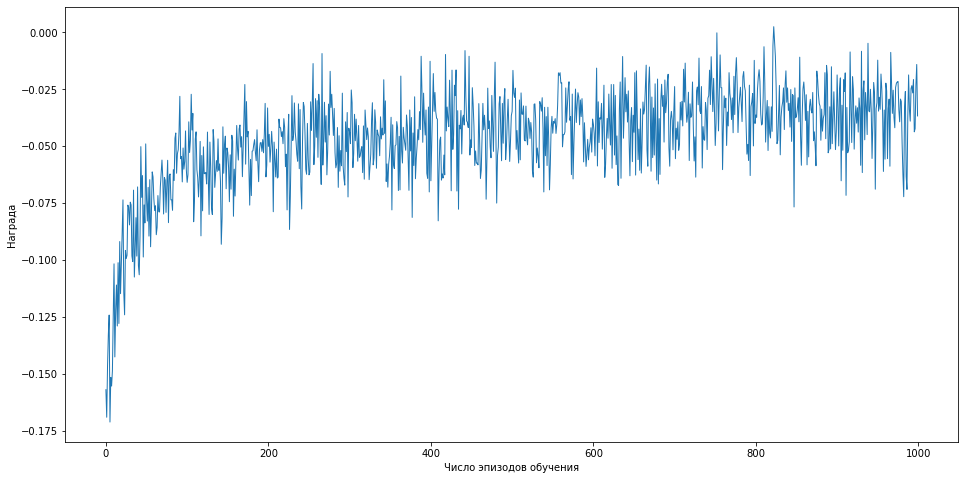

In [134]:
plot_learinig(env, A, alpha=0.00005, epsilon=0.95)

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
- Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [188]:
env = BlackjackDoubleEnv(natural=True)
A = (0, 1, 2)

S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [136]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.00005, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi)

print(f'Оценка выигрыша в варианте с double при стратегии, обученной с помощью Q-обучения: {reward_mean:.5f}')

100%|██████████| 100000/100000 [00:04<00:00, 24193.78it/s]

Оценка выигрыша в варианте с double при стратегии, обученной с помощью Q-обучения: -0.01793


**Попробуем снова подобрать новую alpha и epsilon**

In [138]:
for epsilon in np.linspace(0.05, 1, 20):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.0002, epsilon=epsilon, disable_tqdm=True)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi, disable_tqdm=True)
    print(f'epsilon={epsilon:.5f}, reward={(reward / tries):.5f}')

epsilon=0.05000, reward=-0.08980
epsilon=0.10000, reward=-0.08600
epsilon=0.15000, reward=-0.08792
epsilon=0.20000, reward=-0.07672
epsilon=0.25000, reward=-0.07255
epsilon=0.30000, reward=-0.07151
epsilon=0.35000, reward=-0.07996
epsilon=0.40000, reward=-0.05641
epsilon=0.45000, reward=-0.05745
epsilon=0.50000, reward=-0.05297
epsilon=0.55000, reward=-0.05584
epsilon=0.60000, reward=-0.04780
epsilon=0.65000, reward=-0.03817
epsilon=0.70000, reward=-0.03793
epsilon=0.75000, reward=-0.03600
epsilon=0.80000, reward=-0.03137
epsilon=0.85000, reward=-0.02790
epsilon=0.90000, reward=-0.02719
epsilon=0.95000, reward=-0.02258
epsilon=1.00000, reward=-0.02560


In [139]:
for alpha in [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]: #np.linspace(0.001, 0.02, 20):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=100_000, alpha=alpha, epsilon=0.95, disable_tqdm=True)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi, disable_tqdm=True)
    print(f'alpha={alpha:.5f}, reward={(reward / tries):.5f}')

alpha=0.00001, reward=-0.02908
alpha=0.00002, reward=-0.02619
alpha=0.00005, reward=-0.02899
alpha=0.00010, reward=-0.02631
alpha=0.00020, reward=-0.02432
alpha=0.00050, reward=-0.02621
alpha=0.00100, reward=-0.03171
alpha=0.00200, reward=-0.04119
alpha=0.00500, reward=-0.06374
alpha=0.01000, reward=-0.10181
alpha=0.02000, reward=-0.14326
alpha=0.05000, reward=-0.13706


In [189]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.0002, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi)

print(f'Оценка выигрыша в варианте с double при стратегии, обученной с помощью Q-обучения: {reward_mean:.5f}')

100%|██████████| 100000/100000 [00:04<00:00, 24668.15it/s]

Оценка выигрыша в варианте с double при стратегии, обученной с помощью Q-обучения: -0.02730


Мы уже довольно близко :)

100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]

Награда каждого эпизода усреднена по 50 экспериментам и посчитана на 100 раздачах. Всего 1000 эпизодов


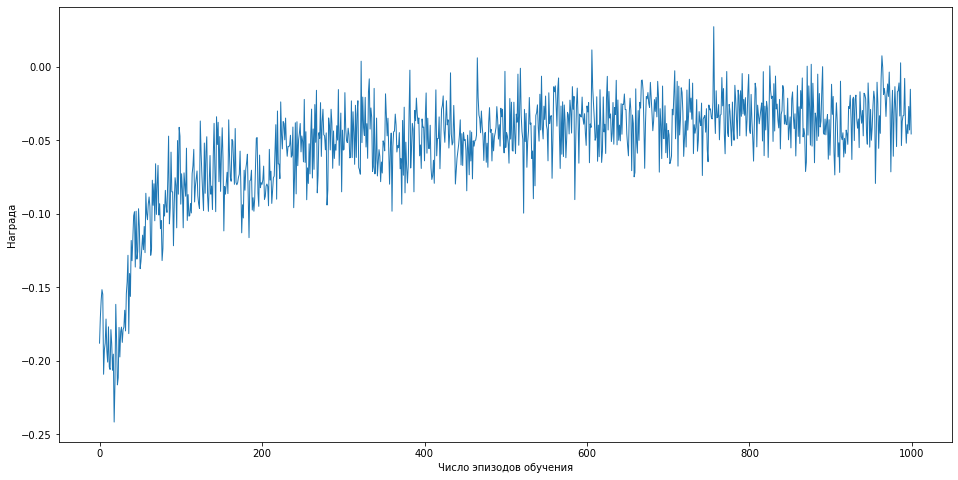

In [144]:
plot_learinig(env, A, alpha=0.0002, epsilon=0.95)

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.
- Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.



----------------------

Будем считать карты по системе «Половинки» из статьи https://ru.wikipedia.org/wiki/Блэкджек#Отслеживание_карт

- Считаем карты игрока сразу после получения
- Считаем после раздачи только 1-ю карту диллера
- После того, как открываются карты, считаем остальные карты диллера
- Если перед началом игры карт остается меньше 15, собираем новую колоду
- Всего очков по системе «Половинки» может быть от -44 до 44 (я округлил до целых, умножив на 2)

In [168]:
env = BlackjackDoubleCountingEnv(natural=True)
A = (0, 1, 2)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False), range(-44, 45)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

Состояний получается в 89 раз больше. Попробуем взять хотя бы в 5 раз больше эпизодов для обучения

In [171]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=500_000, alpha=0.0002, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=500_000)

print(f'Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : {reward_mean:.5f}')

100%|██████████| 500000/500000 [00:22<00:00, 22425.37it/s]

Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : 0.01761


### Ура! Мы обыграли казино! :)

**И снова попробуем подобрать новую alpha и epsilon**

In [149]:
for epsilon in np.linspace(0.05, 1, 20):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=500_000, alpha=0.0002, epsilon=epsilon, disable_tqdm=True)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi, disable_tqdm=True)
    print(f'epsilon={epsilon:.5f}, reward={(reward / tries):.5f}')

epsilon=0.05000, reward=-0.05509
epsilon=0.10000, reward=-0.03858
epsilon=0.15000, reward=-0.03257
epsilon=0.20000, reward=-0.03626
epsilon=0.25000, reward=-0.02902
epsilon=0.30000, reward=-0.02718
epsilon=0.35000, reward=-0.02035
epsilon=0.40000, reward=-0.01357
epsilon=0.45000, reward=-0.01212
epsilon=0.50000, reward=-0.00753
epsilon=0.55000, reward=-0.00614
epsilon=0.60000, reward=-0.00304
epsilon=0.65000, reward=0.00473
epsilon=0.70000, reward=0.00672
epsilon=0.75000, reward=0.00791
epsilon=0.80000, reward=0.01060
epsilon=0.85000, reward=0.01535
epsilon=0.90000, reward=0.01348
epsilon=0.95000, reward=0.01725
epsilon=1.00000, reward=0.01879


In [150]:
for alpha in [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]: #np.linspace(0.001, 0.02, 20):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=500_000, alpha=alpha, epsilon=0.95, disable_tqdm=True)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi, disable_tqdm=True)
    print(f'alpha={alpha:.5f}, reward={(reward / tries):.5f}')

alpha=0.00001, reward=0.01745
alpha=0.00002, reward=0.01866
alpha=0.00005, reward=0.01821
alpha=0.00010, reward=0.01750
alpha=0.00020, reward=0.01472
alpha=0.00050, reward=0.01566
alpha=0.00100, reward=0.01544
alpha=0.00200, reward=0.01525
alpha=0.00500, reward=0.00982
alpha=0.01000, reward=0.00135
alpha=0.02000, reward=-0.00767
alpha=0.05000, reward=-0.04435


In [154]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=500_000, alpha=0.00002, epsilon=1)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=500_000)

print(f'Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : {reward_mean:.5f}')

100%|██████████| 500000/500000 [00:23<00:00, 20912.95it/s]

Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : 0.01850


100%|██████████| 1000/1000 [04:00<00:00,  4.15it/s]

Награда каждого эпизода усреднена по 50 экспериментам и посчитана на 100 раздачах. Всего 1000 эпизодов


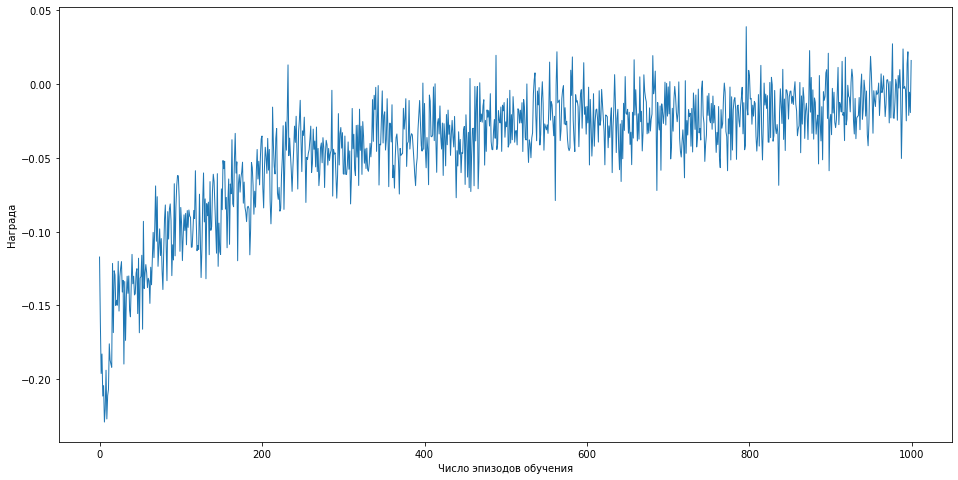

In [153]:
plot_learinig(env, A, alpha=0.00002, epsilon=1)

## Часть четвёртая, опциональная

Реализуйте вариант из второй или третьей части, в котором есть ещё возможность делать split: в случае, когда игроку пришли две одинаковые карты, он может разбить руку на две, внести ещё одну ставку и продолжать играть две руки сразу (как будто за двоих игроков). Скорее всего, обыграть казино получится только в варианте с разрешённым split’ом и подсчётом карт; если получится, это будет отличное завершение проекта!

----------

Чтобы не плодить дикое число состояний со split, для игры со сплитом сделаем так:
- Сначала играем первую игру. 
- Когда игра заканчиваеися, мы не получаем награды. Вместо этого меняем состояние, которое обозначает 2-ю игру 
- Играем 2-ю игру так же, как первую.
- Получаем общую награду

In [218]:
env = BlackjackDoubleCountingSplitEnv(natural=True)
A = (0, 1, 2, 3)
S = list(itertools.product(
    range(2, 32), 
    range(1, 11), 
    (True, False), 
    range(-44, 45),
    range(4),
))

S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}
no_split_ids = [s2idx[s] for s in S if s[4] != 1] # состояние, где сплит недоступен

In [174]:
Q = np.zeros((len(S), len(A)))
Q[no_split_ids, 3] = -np.inf # чтобы не выбирать split когда он недоступен
Q = Q_learning(env, A, Q, episodes=1_000_000, alpha=0.00002, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=500_000)

print(f'Оценка выигрыша в варианте с double, подсчетом карт и split при стратегии, обученной с помощью Q-обучения : {reward_mean:.5f}')

100%|██████████| 500000/500000 [00:22<00:00, 21755.04it/s]


Оценка выигрыша в варианте с double, подсчетом карт и split при стратегии, обученной с помощью Q-обучения : 0.02124


In [166]:
for alpha in [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]: #np.linspace(0.001, 0.02, 20):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q[no_split_ids, 3] = -np.inf
        Q = Q_learning(env, A, Q, episodes=500_000, alpha=alpha, epsilon=0.95, disable_tqdm=True)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi, disable_tqdm=True)
    print(f'alpha={alpha:.5f}, reward={(reward / tries):.5f}')

alpha=0.00001, reward=0.01334
alpha=0.00002, reward=0.01773
alpha=0.00005, reward=0.01731
alpha=0.00010, reward=0.01802
alpha=0.00020, reward=0.01763
alpha=0.00050, reward=0.01504
alpha=0.00100, reward=0.01514
alpha=0.00200, reward=0.01236
alpha=0.00500, reward=0.00650
alpha=0.01000, reward=-0.00916
alpha=0.02000, reward=-0.03016
alpha=0.05000, reward=-0.05696


In [219]:
Q = np.zeros((len(S), len(A)))
Q[no_split_ids, 3] = -np.inf # чтобы не выбирать split когда он недоступен
Q = Q_learning(env, A, Q, episodes=5_000_000, alpha=0.00001, epsilon=1)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=1_000_000)

print(f'Оценка выигрыша в варианте с double, подсчетом карт и split при стратегии, обученной с помощью Q-обучения : {reward_mean:.5f}')

100%|██████████| 1000000/1000000 [00:46<00:00, 21551.59it/s]


Оценка выигрыша в варианте с double, подсчетом карт и split при стратегии, обученной с помощью Q-обучения : 0.02172
